# Model Testing Notebook
This notebook contains the modelling dependencies, consolidated and without the training code infrastructure. This allows you to create a model with the same dimensions as the one you're training, load the weights from a saved checkpoint, and run prompting tests on it.

In [17]:
# One additional dependency for this notebok
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 33.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 27.3 MB/s eta 0:00:00


In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import torch
import math
import torch.nn as nn
from torch.nn import functional as F
from enum import Enum
from dataclasses import dataclass
from IPython import display
from torchinfo import summary
import tiktoken
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import trange
import torch.jit as jit
from typing import List
import globals as g
from modelling_utils import apply_rotary_pos_emb, repeat_kv, Transformer, clean_class_name, pretty_generate
from training_utils import plot_grad_flow, get_lr, get_batch, generate_training_data
import wandb
import os
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.decomposition import PCA
import time
import numpy as np
g.get_device()

Using cuda


In [20]:
class AbsolutePositionalEmbeddings(nn.Module):
    """
    GPT-2 style word-token embeddings + absolute positional embeddings
        Combines word-token-embeddings and word-position-embeddings to transmit
        both pieces of information throughout the rest of the model
    """
    def __str__(self):
        return "AbsolutePositionalEmbeddings"
        
    def __init__(self, config):
        super().__init__()
        # Validity assertions
        assert config.max_seq_len > 0, f"Max positional embeddings must be > 0: set max_seq_len positive"
        
        self.vocab_size = config.vocab_size
        self.n_embed = config.n_embd
        self.max_positional_embeddings = config.max_seq_len

        self.wte = nn.Embedding(self.vocab_size, self.n_embed)
        self.wpe = nn.Embedding(self.max_positional_embeddings, self.n_embed)
        self.drop = nn.Dropout(config.dropout)

    def forward(self, idx):
        # Batch, seq_len
        b, seq_len = idx.size()
        assert seq_len <= self.max_positional_embeddings, f"Input sequence length {seq_len} is greater than max positional embeddings of {self.max_positional_embeddings}"

        tok_emb = self.wte(idx)
        pos_emb = self.wpe(torch.arange(0, seq_len, dtype=torch.long, device=idx.device))
        emb = self.drop(tok_emb + pos_emb)
        return emb

class WordTokenEmbeddings(nn.Module):
    """
    Word-token-embeddings only
        For use in other architectures that handle positional embeddings
        differently (e.g. LLama)
    """
    def __str__(self):
        return "WordTokenEmbeddings"
        
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config.vocab_size
        self.n_embed = config.n_embd

        self.wte = nn.Embedding(self.vocab_size, self.n_embed)
        self.drop = nn.Dropout(config.dropout)

    def forward(self, idx):
        tok_emb = self.wte(idx)
        return self.drop(tok_emb)

class LlamaRotaryEmbedding(nn.Module):
    """
    LLama-style rotary embeddings adapted from Transformers LLama source
    https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L94

        !!Applied in the self-attention module, not as part of embedding block!!
    """
    def __str__(self):
        return "RotaryPositionalEmbedding"
        
    def __init__(self, dim, max_position_embeddings=1024, base=10000, device=None, scaling_factor=1.0):
        super().__init__()
        self.scaling_factor = scaling_factor
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        # For BC we register cos and sin cached
        self.max_seq_len_cached = max_position_embeddings

    @torch.no_grad()
    def forward(self, x):
        # x: [bs, num_attention_heads, seq_len, head_size]
        bs,nh,sl,embd = x.size()
        position_ids = torch.arange(0,sl, device=x.device).unsqueeze(0)
        # float32 precision required according to source
        # https://github.com/huggingface/transformers/pull/29285
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()
        
        freqs = (inv_freq_expanded @ position_ids_expanded).transpose(1, 2)
        emb = torch.cat((freqs, freqs), dim=-1)
        cos = emb.cos()
        sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)

class MHASelfAttention(nn.Module):
    """
    LLama-style Multi-Head Attention with rotary embeddings
    https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L577

    Modified to include same manual attention fallback
    """
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # Key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.o_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Regularization
        self.resid_dropout = nn.Dropout(config.dropout)
        self.using_rotary_encoding = False
        if config.rotary_encoding:
            self.rotary_emb = LlamaRotaryEmbedding(config.n_embd//config.n_head, max_position_embeddings = config.max_seq_len)
            self.using_rotary_encoding = True
        else:
            self.rotary_emb = None
        
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # Causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.max_seq_len, config.max_seq_len))
                                        .view(1, 1, config.max_seq_len, config.max_seq_len))
    
    def forward(self, x, position_embeddings = None):
        B, T, C = x.size() # Batch size, sequence length, embedding dimensionality (n_embd)

        # Calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        """
        Primary difference in positional embeddings implementation.
        This encodes the positions of each part of the inputs into the attention
        matrix, as opposed to encoding it directly into the embedding trajectory
        """
        if self.using_rotary_encoding:
            if position_embeddings is None:
                cos, sin = self.rotary_emb(v)
            else:
                cos, sin = position_embeddings
            q, k = apply_rotary_pos_emb(q, k, cos, sin)
        
        # Causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v
            
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.o_proj(y))
        return y

class GQASelfAttention(nn.Module):
    """
    LLama-style Grouped Query Attention with rotary embeddings
    https://arxiv.org/pdf/2305.13245
    https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L577

    Causal SA is really just the case where the number of KV heads is equal to the number of Q heads,
    but I've separated it here to have a "simpler" case available. Compilation *should* take care
    of most of the performance differences w/r/t performing matrix multiplications in one go or not
    """
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        assert config.n_head % config.n_kv_head == 0
        
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = self.n_embd//self.n_head
        self.num_key_value_heads = config.n_kv_head
        self.num_key_value_groups = self.n_head // self.num_key_value_heads
        
        # Q, K, and V aren't identical in size anymore, so can't batch all in one MatMul
        self.q_proj = nn.Linear(self.n_embd, self.n_head*self.head_dim, bias = config.bias)
        self.k_proj = nn.Linear(self.n_embd, self.num_key_value_heads*self.head_dim, bias = config.bias)
        self.v_proj = nn.Linear(self.n_embd, self.num_key_value_heads*self.head_dim, bias = config.bias)
        
        # Output projection
        self.o_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        
        # Regularization
        self.resid_dropout = nn.Dropout(config.dropout)

        
        self.using_rotary_encoding = False
        if config.rotary_encoding:
            self.rotary_emb = LlamaRotaryEmbedding(config.n_embd//config.n_head, max_position_embeddings = config.max_seq_len)
            self.using_rotary_encoding = True
        else:
            self.rotary_emb = None
        
        self.dropout = config.dropout
        
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # Causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.max_seq_len, config.max_seq_len))
                                        .view(1, 1, config.max_seq_len, config.max_seq_len))

    def forward(self, x, position_embeddings = None):
        B, T, C = x.size() # Batch size, sequence length, embedding dimensionality (n_embd)

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2) # (B, nh, T, hs)
        k = k.view(B, T, self.num_key_value_heads, self.head_dim).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.num_key_value_heads, self.head_dim).transpose(1, 2) # (B, nh, T, hs)

        
        if self.using_rotary_encoding:
            if position_embeddings is None:
                cos, sin = self.rotary_emb(v)
            else:
                cos, sin = position_embeddings
            q, k = apply_rotary_pos_emb(q, k, cos, sin)

        """
        Primary difference with rotary MHA -- KV groups are repeated to match
        Q dimension before being passed through SDPA
        """
        k = repeat_kv(k, self.num_key_value_groups)
        v = repeat_kv(v, self.num_key_value_groups)
        
        # Causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v
            
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.o_proj(y))
        return y


"""
A "fun" alternative architecture based on RNNs. Also much slower for similar sequence lengths!
https://arxiv.org/pdf/2402.19427
RNNs are the "old" way of doing NLP, and have had some minor resurgence recently.
They are much more memory-efficient in the forward pass - since Attention requires
memory in some linear (with Flash Attention 2, otherwise it's quadratic) relation
with the amount of text passed into it, an RNN requires the same amount of memory
for any input lengths, it just takes longer as it passes each step through. 

First part to define is the RG-LRU cell, which performs a single "time step"
"""
class RGLRUCell(jit.ScriptModule):
    def __init__(self, input_size, hidden_size, epsilon = 1e-10):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.c = -8  # Scalar-valued constant
        self.eps = epsilon

        # Initialize weights
        # We're combining the Wa and Wx matrices to reduce the operations 
        # to a single mat-mul. We can then chunk out the rt and it halves
        self.WaWx = nn.Linear(input_size, 2*hidden_size)
        
        self.Lambda = nn.Parameter(torch.Tensor(hidden_size))  # Λ
        # Initialize parameters
        self.reset_parameters()
        
    def reset_parameters(self):
        self.Lambda.data.uniform_(
            torch.logit(torch.tensor(0.9)),
            torch.logit(torch.tensor(0.999)),
        )    
    @jit.script_method    
    def forward(self, xt, state):
        rt_it = self.WaWx(xt)
        rt, it = rt_it.split(self.hidden_size, dim=2)
        rt = torch.sigmoid(rt)
        it = torch.sigmoid(it)
        a = torch.sigmoid(self.Lambda)
        at = a**rt
        # In my experimentation, an epsilon term was required to prevent
        # infinite gradients - because the derivative of (1 - x)^0.5 @ x = 1
        # is infinite... ¯\_(ツ)_/¯ wasn't mentioned in the paper
        state = at * state + torch.sqrt(1 - at**2 + self.eps) * (it * xt)
        return state

"""
The RG-LRU Recurrent Block, which passes the input signal through the cell to modify
the hidden state, which is gated by a parallel linear layer.

    I opted to ignore the convolutional step. This doesn't perform well enough
    on my normie hardware (vs Google's dedicated TPUs with handcrafted CUDA kernels)
    to really test vs attention. Might explain why Attention's taken over...
"""
class RGLRURecurrentBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.rglru_hidden_size > 0

        self.rglru_init_h = torch.zeros(config.rglru_hidden_size)
        self.cell = RGLRUCell(config.rglru_hidden_size, config.rglru_hidden_size)

        self.in_gate_proj = nn.Linear(config.n_embd, 2*config.rglru_hidden_size)

        self.out_proj = nn.Linear(config.rglru_hidden_size, config.n_embd)

    def forward(self, x):
        B, T, C = x.size()
        
        xin = self.in_gate_proj(x)
        gate, rnn = xin.chunk(2,-1)
        # RNN
        inputs = rnn.unbind(1)
        state = self.rglru_init_h.repeat(B,1).to(x.device, dtype=x.dtype)
        rnn_outs = torch.jit.annotate(List[torch.Tensor], [])
        for i in range(T):
            state = self.cell(inputs[i], state)
            rnn_outs += [state]
        rnn = torch.stack(rnn_outs).transpose(0,1)
        return self.out_proj(F.gelu(gate)*rnn)

class MLP(nn.Module):
    """
    GPT-2 style MLP feed-forward block
    https://github.com/karpathy/nanoGPT/blob/master/model.py#L78

        Expands embedding dimension to intermediate size, then collapses
        back to pass to next block in transformer
    """
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, config.intermediate_size, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(config.intermediate_size, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class GatedMLP(nn.Module):
    """
    (simplified) LLama-style gated MLP feed-forward block
    https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L186

        More parameters, but gating allows for (theoretically) improved information retention between hidden states
    """
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.n_embd
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=config.bias)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=config.bias)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
        self.act_fn = nn.SiLU()

    def forward(self, hidden_state):
        return self.dropout(self.down_proj(self.act_fn(self.gate_proj(hidden_state)) * self.up_proj(hidden_state)))

class RMSNorm(nn.Module):
    """
    LLama-style RMS norm
    https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L74
    """
    def __init__(self, config, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(config.n_embd))

    def norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x: torch.Tensor):
        return self.weight * self.norm(x.float()).type_as(x)

class Block(nn.Module):
    """
    Standard transformers block structure
        Passed attention class, feed forward class, and layer normalization class

        Forward involves attention residual followed by feed forward residual to be
        passed to next block in transformer
    """
    def __init__(self, config):
        super().__init__()
        self.ln_1 = config.ln_class(config)
        self.attn = config.attn_class(config)
        self.ln_2 = config.ln_class(config)
        self.ff = config.ff_class(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.ff(self.ln_2(x))
        return x      

class TransformerForCausalLM(Transformer):
    """
    Architecturally-relevant pieces based on Karpathy's nanoGPT
    https://github.com/karpathy/nanoGPT/blob/master/model.py#L118
    """
    def __init__(self, config):
        super().__init__()
        self.conf = config
        """
        Transformer decoder stack
            Word token embedding sequences are passed through
            a series of processing blocks before normalization
        """
        self.transformer = nn.ModuleDict(dict(
            # Embeddings + dropout
            wte = config.emb_class(config),
            
            # Backbone of Attn->FF blocks
            h = nn.ModuleList([
                Block(config) for _ in range(config.n_layer)
            ]),

            # Output hidden state normalization
            n_f = config.ln_class(config)
        ))
        """
        Language Modelling "head"
            maps the hidden state output by the transformer decoder stack
            to a token from its vocabulary
        """
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        """
        "Weight Tying"
            From Karpathy, which credits https://paperswithcode.com/method/weight-tying
            
            By making input embeddings and output decodings map within the same space, 
            the generation of a new token is more like a "movement" through this latent space.
            The word embeddings then must be clustered by frequency/semantic usage, with n_embd
            different potential similarities or differences(/nuances).
        """
        self.transformer.wte.wte.weight = self.lm_head.weight

        # Init all weights
        self.apply(self._init_weights)
        # Apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # Report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    """
    Forward method modified from Karpathy
    https://github.com/karpathy/nanoGPT/blob/master/model.py#L118

        Calculates cross entropy loss if targets are provided. Targets are just
        inputs shifted one to the left for foundational training (e.g. which token directly follows the input).
    """
    def forward(self, idx, targets = None):
        device = idx.device
        b, t = idx.size()

        hidden_state = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        for block in self.transformer.h:
            hidden_state = block(hidden_state)
        hidden_state = self.transformer.n_f(hidden_state)

        if targets is not None:
            logits = self.lm_head(hidden_state)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # Inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(hidden_state[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

@dataclass
class Config:
    """
    Default config is a scaled-down version of LLama-3 for ~220M parameters
    """
    max_seq_len = 1024
    vocab_size = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer = 12
    n_head = 16
    n_kv_head = 8
    n_embd = 1024
    intermediate_size = 3584
    dropout = 0.0
    bias = False
    rotary_encoding = True
    
    # What component classes are we using?
    emb_class = WordTokenEmbeddings
    attn_class = GQASelfAttention
    ff_class = GatedMLP
    ln_class = RMSNorm

In [21]:
conf_default = Config()

In [22]:
model = TransformerForCausalLM(conf_default).to(g.device, dtype=g.dtype)
summary(model, input_size=(1, 1024), dtypes=[torch.long],depth=5)
model = torch.compile(model)

number of parameters: 221.41M


In [29]:
# Get list of available model states to load
options = []
for f in os.listdir():
    if ".pt" in f[-4:]: # Capture both .pth and .pt
        options.append(f)
        
def load_model_ckpt(fname):
    if fname == None:
        return
    if ".pth" in fname: # The model's training state, incl. optimizer
        model.load_state_dict(torch.load(fname, map_location=torch.device("cpu"))["model"], strict=False)
    elif ".pt" in fname: # Just the model state dictionary
        model.load_state_dict(torch.load(fname), strict=False)
        
interact(load_model_ckpt, 
         fname = widgets.Dropdown(options=options,description='Model checkpoint:',disabled=False)
        )

interactive(children=(Dropdown(description='Model checkpoint:', options=('ckpt30.pth',), value='ckpt30.pth'), …

<function __main__.load_model_ckpt(fname)>

In [65]:
test_string = """This is a test"""

output = pretty_generate(test_string, model, dev=g.dev, top_k=50)
print(output)

Generating with random seed 165964
 This is a test  brewing discarded ceremoniesBlack Doll masses shame Robinson THEM yawn Enemiesranged massesociateleyseas Anitaoward pope yawn DIS resurrectultane sweeping gear ethic Anita masses Jordcash Jord Teachers 368�cers slicing majestic Walesership Australianscers gear yawn regimesoward Jord lacked slicingincent collisionRubokin yawnIsraeli hip containing rand Jord Experiment speeches sparsefuel Principal proofealous bottled caution label collision Teachers rand ExperimentincentebIsraeli suscept TPIsraeli platform litter comaBride eject accur cradle claimant={ suscept Byrd moanRubCompar connectoranded SUPPORT Il HolocaustCompar label227 claimant={keeper platformamoto Hallkeeper TR Steam Destroyyards bottleantom Arizona Arizona NASL Limbaughthird bottleebfuel Adobe Nebulathirdealous claimant Grandelta churches Sanchezthird caution HAL22 Arizona slicingWT pocket caution TR TR churches electoral claimant caution王王 Tasteelta Sanchezyards churches 

In [66]:
enc = tiktoken.get_encoding("gpt2")

# Get embeddings of each word in the sequence, capture whether it was prompt or output
with torch.no_grad():
    prompt_traj = model.transformer.wte(
        torch.Tensor(enc.encode_ordinary(test_string)).view(-1).long().to(g.dev)
    ).cpu().float()
    
    response_traj = model.transformer.wte(
        torch.Tensor(enc.encode_ordinary(output[prompt_traj.size()[0]:])).view(-1).long().to(g.dev)
    ).cpu().float()

In [54]:
prompt_traj.size()

torch.Size([4, 1024])

In [55]:
response_traj.size()

torch.Size([229, 1024])

In [70]:
pca = PCA(n_components=3)
pca.fit(prompt_traj)
full_traj = pca.transform(torch.cat([prompt_traj, response_traj], dim=0))
inp_strings_tok = [enc.decode([t]) for t in enc.encode_ordinary(test_string)]
out_strings_tok = [enc.decode([t]) for t in enc.encode_ordinary(output)]

<Figure size 800x800 with 0 Axes>

NameError: name 'promttraj' is not defined

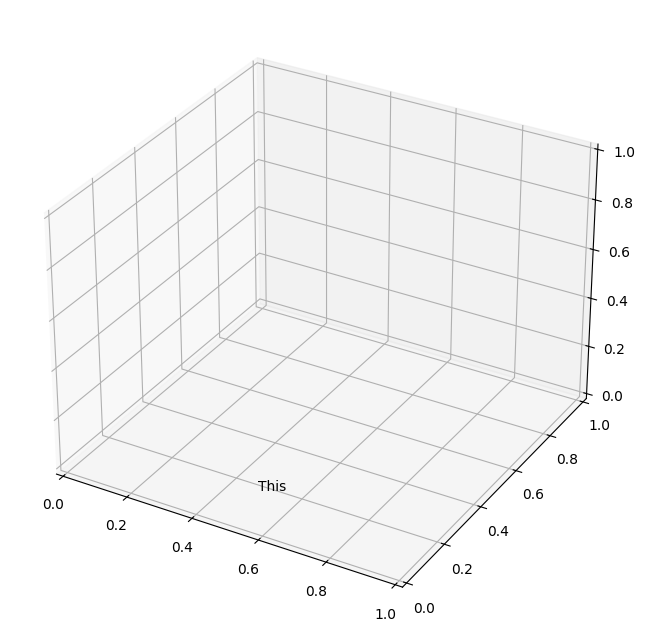

In [72]:
f = plt.figure(figsize=(8,8))
dh = display.display(f, display_id=True)
ax = f.add_subplot(projection='3d')

prompt_pts = []
out_pts = []
for q in np.arange(0, full_traj.shape[0]):
    if q < len(prompt_traj):
        tok = inp_strings_tok[q]
        ax.text(full_traj[q,0], full_traj[q,1], full_traj[q,2], tok, color='black')
        prompt_pts.append([full_traj[q,0], full_traj[q,1], full_traj[q,2]])
    else:
        tok = out_strings_tok[q-len(prompt_traj)]
        ax.text(full_traj[q,0], full_traj[q,1], full_traj[q,2], tok, color='red')
        out_pts.append([full_traj[q,0], full_traj[q,1], full_traj[q,2]])

    prompttraj = np.array(prompt_pts)
    outtraj = np.array(out_pts)
    if promttraj.shape[0] > 1:
        ax.plot(prompttraj[:,0], prompttraj[:,1], prompttraj[:,2], color='black', alpha=0.1)
    if outtraj.shape[0] > 1:
        ax.plot(outtraj[:,0], outtraj[:,1], outtraj[:,2], color='red', alpha=0.1)

    ax.set_xlim(np.min(full_traj[:,0]), np.max(full_traj[:,0]))
    ax.set_ylim(np.min(full_traj[:,1]), np.max(full_traj[:,1]))
    ax.set_zlim(np.min(full_traj[:,2]), np.max(full_traj[:,2]))

    dh.update(f)
    time.sleep(1.0/10)